# Carlini Wagner

The Carlini-Wagner attack is a little like PGD in that the optimization function seeks to perturb the image in such a way it is not directly observable to humans. However this attack uses the Adam optimizer (rather than focusing on the gradient function and its direction) to finetune the perturbations, making it more robust.

First we import all the required packages.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

Now we download the iris data from the datasets library, which contains 4 features per flower sample and 3 class labels (Setosa, Versicolor, Virginica). We do our standard preprocessing - transforming features.

In [2]:
# Load and Preprocess Iris Dataset
iris = datasets.load_iris()
X, y = iris.data, iris.target

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

We convert the NumPy arrays into PyTorch tensors, split into 80% training and 20% test set, and organise the data into test sets with a batch size of 16.

In [3]:
# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Convert to PyTorch Datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

We define a simple neural network (multi-layer perceptron) with input layer (4 features), hidden layer (10 neurons, ReLU activation) and output layer (3 neurons, one per class).

In [4]:
# Define Simple MLP Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(4, 10)  # Input: 4 features → Hidden: 10 neurons
        self.fc2 = nn.Linear(10, 3)  # Hidden: 10 neurons → Output: 3 classes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Initialize Model
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

We define a training function which trains the model for 100 epochs, updating the model weights via gradient descent. The loss is printed every 20 epochs for tracking progress.

In [5]:
# Train Model
def train_model():
    model.train()
    for epoch in range(100):  # 100 epochs for training
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        if epoch % 20 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

train_model()

Epoch 0, Loss: 1.0386090278625488
Epoch 20, Loss: 0.15431679785251617
Epoch 40, Loss: 0.01236178632825613
Epoch 60, Loss: 0.018461553379893303
Epoch 80, Loss: 0.0006165315862745047


We define the Carlini-Wagner attack function to generate adversarial examples by minimising the L2 distance while ensuring the model misclassifies the input. A single test sample (X_sample) is selected for attack, a small adversarial perturbation (delta) is initialised as zero and the optimizer updates delta iteratively to generate the adversarial example.

In [6]:
# Carlini-Wagner Attack for Tabular Data
def carlini_wagner_attack(model, X_sample, y_true, c=0.1, lr=0.01, max_iterations=100):
    """
    Carlini-Wagner Attack for the Iris dataset.

    - model: Trained PyTorch model
    - X_sample: Single input sample (1x4)
    - y_true: True label (integer)
    - c: Attack trade-off constant
    - lr: Learning rate for optimization
    - max_iterations: Maximum steps
    """
    X_sample = X_sample.clone().detach().unsqueeze(0)  # Ensure batch dimension
    delta = torch.zeros_like(X_sample, requires_grad=True)  # Perturbation
    optimizer = optim.Adam([delta], lr=lr)

    def loss_function(logits, true_label, delta, X_sample, c):
        """CW Attack loss: L2 distance + misclassification loss"""
        l2_distance = torch.norm(delta, p=2)
        true_class_score = logits[:, true_label]
        max_wrong_class_score = (logits - torch.eye(logits.shape[1])[true_label].to(logits.device) * 1e6).max(dim=1)[0]
        misclassification_loss = torch.clamp(true_class_score - max_wrong_class_score + c, min=0)
        return l2_distance + misclassification_loss

    for iteration in range(max_iterations):
        optimizer.zero_grad()
        perturbed_input = X_sample + delta
        logits = model(perturbed_input)

        loss = loss_function(logits, y_true, delta, X_sample, c)
        loss.backward()
        optimizer.step()

        # Keep perturbation within valid range
        delta.data = torch.clamp(delta, -1.5, 1.5)

        if iteration % 20 == 0:
            print(f"Iteration {iteration}: Loss = {loss.item()}")

    return (X_sample + delta).detach(), delta.detach()

# Select a Test Sample and Apply the Attack
index = 5
X_sample = X_test[index]  # Pick one test sample
y_true = y_test[index].item()  # True label

print(f"\nOriginal Class: {iris.target_names[y_true]}")

adv_example, perturbation = carlini_wagner_attack(model, X_sample, y_true)


Original Class: setosa
Iteration 0: Loss = 8.102930068969727
Iteration 20: Loss = 6.164970874786377
Iteration 40: Loss = 4.221742630004883
Iteration 60: Loss = 1.8319313526153564
Iteration 80: Loss = 1.4396415948867798


We check if the model was successfully fooled by comparing original and adversarial predictions.

In [7]:
# Compare Original vs. Adversarial Prediction
original_pred = torch.argmax(model(X_sample.unsqueeze(0)))
adv_pred = torch.argmax(model(adv_example))

print(f"Original Prediction: {iris.target_names[original_pred]}")
print(f"Adversarial Prediction: {iris.target_names[adv_pred]}")
print(f"Perturbation Applied: {perturbation.numpy()}")

Original Prediction: setosa
Adversarial Prediction: versicolor
Perturbation Applied: [[ 0.65395826 -0.69287884  0.7214465   0.71555215]]


We then plot the perturbation impact.

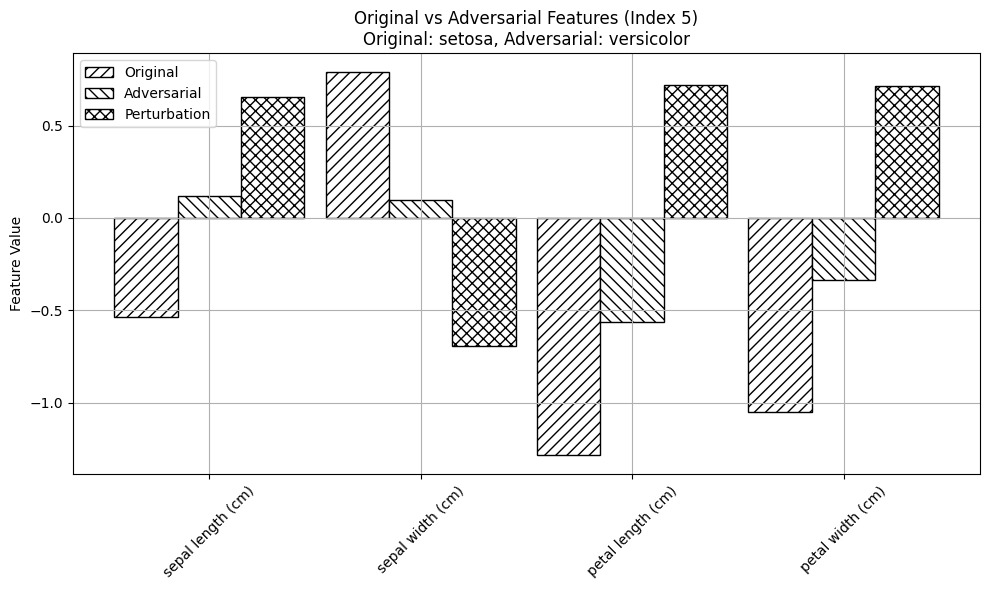

In [8]:
# Convert tensors to NumPy arrays for plotting
original_features = X_sample.detach().numpy()
adversarial_features = adv_example.squeeze().numpy()
perturbation_values = perturbation.squeeze().numpy()

feature_names = iris.feature_names
x = np.arange(len(feature_names))  # Feature indices for plotting

# Plot original vs adversarial features using hatching patterns
plt.figure(figsize=(10, 6))
width = 0.3

bars1 = plt.bar(x - width, original_features, width=width, label='Original', color='white', edgecolor='black', hatch='///')
bars2 = plt.bar(x, adversarial_features, width=width, label='Adversarial', color='white', edgecolor='black', hatch='\\\\\\')
bars3 = plt.bar(x + width, perturbation_values, width=width, label='Perturbation', color='white', edgecolor='black', hatch='xxx')

plt.xticks(ticks=x, labels=feature_names, rotation=45)
plt.ylabel("Feature Value")
plt.title(f"Original vs Adversarial Features (Index {index})\nOriginal: {iris.target_names[y_true]}, Adversarial: {iris.target_names[adv_pred]}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
